#**Task 2: Clustering**
##DSMarket ALAN V1



#**Clustering de Tiendas**

#Librerias y ficheros

In [36]:
# silence warnings
import warnings
warnings.filterwarnings("ignore")

# operating system
import os

# time calculation to track some processes
import time

# numeric and matrix operations
import numpy as np
import pandas as pd

# loading ploting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# python core library for machine learning and data science
import sklearn
from sklearn import set_config
set_config(transform_output = "pandas")

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
#CWD = os.getcwd()
#PATH_DATA = os.path.join(CWD, "data")

#Importamos fichero

In [39]:
df = pd.read_csv("/content/drive/MyDrive/DSMarket/DatosAgrupadosEnSemanas.csv.gz")
df.head()

,id,item,category,department,store,store_code,region,año,semana,trimestre,event,ventas,yearweek,sell_price
0,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011,4,1,Sin_Evento,0,201104,12.74
1,ACCESORIES_1_002_BOS_1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011,4,1,Sin_Evento,0,201104,5.28
2,ACCESORIES_1_003_BOS_1,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011,4,1,Sin_Evento,0,201104,3.95
3,ACCESORIES_1_004_BOS_1,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011,4,1,Sin_Evento,3,201104,5.77
4,ACCESORIES_1_005_BOS_1,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011,4,1,Sin_Evento,0,201104,3.63


In [40]:
store_unique = df['store_code'].nunique()
print(f"Tenemos un total de {store_unique} tiendas únicas en el dataset.")

Tenemos un total de 10 tiendas únicas en el dataset.




---



#Feature Engineering

**Temporales**

In [41]:
df['date'] = pd.to_datetime(df['yearweek'].astype(str) + '0', format='%Y%W%w')
df['month'] = df['date'].dt.month

In [42]:
df['quarter'] = df['date'].dt.to_period('Q')

In [43]:
df['is_event'] = np.where(df['event'] == 'Sin_Evento', 0, 1)

In [44]:
df['date'].min()

Timestamp('2011-01-30 00:00:00')

In [45]:
df['date'].max()

Timestamp('2016-04-24 00:00:00')

Filtramos datos para solo utilizar 2011 hasta 2015.

In [46]:
# Filter data to include only the selected years (2011 to 2015)
df_filtered = df[(df['date'].dt.year >= 2011) & (df['date'].dt.year <= 2015)].copy()

In [47]:
total_sales_all_stores = df_filtered['ventas'].sum()
print(f"Total sales of all stores combined: {total_sales_all_stores}")

Total sales of all stores combined: 60584837


## **Venta**

**Proporción de Ventas de la Tienda respecto a Ventas Totales**

Fórmula: Proporción de Ventas = Ventas de la Tienda / Ventas Totales

Interpretación: Mide la participación de cada tienda en las ventas totales. Esto puede ayudarte a identificar qué tiendas contribuyen más o menos a las ventas generales.

In [48]:
df_store_sales = df_filtered.groupby('store_code')['ventas'].sum().reset_index()
df_store_sales.rename(columns={'ventas': 'total_ventas_store'}, inplace=True)
df_store_sales['total_ventas'] = df_filtered['ventas'].sum()
df_store_sales['store_sales_ratio'] = df_store_sales['total_ventas_store'] / df_store_sales['total_ventas']
df_store_sales

,store_code,total_ventas_store,total_ventas,store_sales_ratio
0,BOS_1,5196742,60584837,0.085776
1,BOS_2,6716413,60584837,0.110860
2,BOS_3,5619240,60584837,0.092750
3,NYC_1,7150276,60584837,0.118021
4,NYC_2,5158594,60584837,0.085147
5,NYC_3,10408776,60584837,0.171805
6,NYC_4,3789517,60584837,0.062549
7,PHI_1,4679823,60584837,0.077244
8,PHI_2,5918432,60584837,0.097688
9,PHI_3,5947024,60584837,0.098160


**Ventas Promedio por Categoría o Departamento**

Fórmula: Ventas Promedio por Categoría = Ventas de la Categoría en la Tienda / Número de Categorías en la Tienda

Interpretación: Indica la eficiencia de ventas de diferentes categorías dentro de cada tienda. Puede ser útil para comparar tiendas que venden diferentes productos.

In [49]:
df_avg_sales_category = df_filtered.groupby(['store_code', 'category'])['ventas'].mean().reset_index()
df_avg_sales_category.columns = ['store_code', 'category', 'avg_sales_per_category']
df_avg_sales_category = df_avg_sales_category.pivot(index='store_code', columns='category', values='avg_sales_per_category')
df_avg_sales_category.columns = ['avg_sales_cat_' + col for col in df_avg_sales_category.columns]
df_avg_sales_category.reset_index(inplace=True)
df_avg_sales_category

,store_code,avg_sales_cat_ACCESORIES,avg_sales_cat_HOME_&_GARDEN,avg_sales_cat_SUPERMARKET
0,BOS_1,2.563906,4.464155,9.034859
1,BOS_2,3.842335,5.033299,12.005506
2,BOS_3,3.117641,4.496429,9.874560
3,NYC_1,5.275482,4.627781,12.847492
4,NYC_2,3.820484,5.038292,8.024881
5,NYC_3,5.776809,8.786800,17.956773
6,NYC_4,3.364491,2.305221,6.692793
7,PHI_1,3.935014,3.375857,7.966198
8,PHI_2,2.191788,4.437268,11.047155
9,PHI_3,2.820790,3.970100,11.213373


**Ratio de Ventas por Semana o Trimestre**

Fórmula: Ratio de Ventas por Semana = Ventas de la Tienda en la Semana / Número de Semanas

Interpretación: Muestra el promedio de ventas semanal, ayudando a entender el comportamiento estacional o la estabilidad de las ventas a lo largo del tiempo.

In [50]:
df_sales_quarter = df_filtered.groupby(['store_code', 'trimestre'])['ventas'].sum().reset_index()
df_sales_quarter = df_sales_quarter.pivot(index='store_code', columns='trimestre', values='ventas')
df_sales_quarter.columns = ['ventas_T1', 'ventas_T2', 'ventas_T3', 'ventas_T4']
df_sales_quarter.reset_index(inplace=True)
df_sales_quarter

,store_code,ventas_T1,ventas_T2,ventas_T3,ventas_T4
0,BOS_1,1189322,1338839,1398755,1269826
1,BOS_2,1552176,1708936,1810848,1644453
2,BOS_3,1270261,1423469,1533950,1391560
3,NYC_1,1613848,1833796,1933737,1768895
4,NYC_2,1137347,1272562,1439255,1309430
5,NYC_3,2369606,2638215,2860873,2540082
6,NYC_4,863583,961723,1013170,951041
7,PHI_1,1093573,1162166,1200671,1223413
8,PHI_2,1366385,1404849,1606412,1540786
9,PHI_3,1462250,1458077,1539923,1486774


**Ratio de Eventos a Ventas**

Fórmula: Ratio de Eventos a Ventas = Número de Eventos en la Tienda / Ventas Totales de la Tienda

Interpretación: Este ratio puede indicar cómo los eventos (promociones, descuentos, etc.) impactan en las ventas totales de la tienda.

**Ratio de Ventas en Días de Evento**

Fórmula: Ratio de Ventas en Días de Evento = Ventas durante Eventos / Ventas Totales

Interpretación: Mide el impacto de los días de eventos en las ventas totales. Puede mostrar si las ventas de una tienda dependen en gran medida de eventos promocionales.**

In [51]:
df_store_event_sales = df_filtered.groupby(['store_code', 'is_event'])['ventas'].sum().reset_index()

df_store_event_sales = df_store_event_sales.pivot(index='store_code', columns='is_event', values='ventas')
df_store_event_sales.columns = ['event_sales', 'no_event_sales']

df_store_event_sales['total_store_sales'] = df_filtered.groupby('store_code')['ventas'].sum()
df_store_event_sales['count_events'] = df_filtered.groupby('store_code')['is_event'].sum()

df_store_event_sales['ratio_eventos_ventas'] = df_store_event_sales['count_events'] / df_store_event_sales['total_store_sales']

df_store_event_sales['ratio_ventas_en_eventos'] = df_store_event_sales['event_sales'] / df_store_event_sales['total_store_sales']

df_store_event_sales.drop(columns=['event_sales','no_event_sales','total_store_sales','count_events'], inplace=True)

df_store_event_sales.reset_index(inplace=True)

df_store_event_sales

,store_code,ratio_eventos_ventas,ratio_ventas_en_eventos
0,BOS_1,0.013494,0.918027
1,BOS_2,0.010441,0.918584
2,BOS_3,0.012480,0.919471
3,NYC_1,0.009808,0.917784
4,NYC_2,0.013594,0.920560
5,NYC_3,0.006737,0.920342
6,NYC_4,0.018506,0.918760
7,PHI_1,0.014985,0.916538
8,PHI_2,0.011849,0.921017
9,PHI_3,0.011792,0.917916


**Ratio de Ventas por Región**

Fórmula: Ratio de Ventas por Región = Ventas de la Tienda / Ventas Totales en la Región

Interpretación: Ayuda a entender cómo cada tienda se desempeña en relación con otras tiendas en la misma región.

In [52]:
df_region_sales = df_filtered.groupby('region')['ventas'].sum().reset_index()
df_region_sales

,region,ventas
0,Boston,17532395
1,New York,26507163
2,Philadelphia,16545279


In [53]:
df_store_sales

,store_code,total_ventas_store,total_ventas,store_sales_ratio
0,BOS_1,5196742,60584837,0.085776
1,BOS_2,6716413,60584837,0.110860
2,BOS_3,5619240,60584837,0.092750
3,NYC_1,7150276,60584837,0.118021
4,NYC_2,5158594,60584837,0.085147
5,NYC_3,10408776,60584837,0.171805
6,NYC_4,3789517,60584837,0.062549
7,PHI_1,4679823,60584837,0.077244
8,PHI_2,5918432,60584837,0.097688
9,PHI_3,5947024,60584837,0.098160


**Ratio de Crecimiento de Ventas Anual**

In [54]:
# Fórmula para sacar Ratio de Crecimiento de Ventas Anual = (Ventas Año Actual - Ventas Año Anterior) / Ventas Año Anterior

df_annual_sales = df_filtered.groupby(['store_code', df_filtered['date'].dt.year])['ventas'].sum().reset_index()

df_annual_sales.rename(columns={'ventas': 'annual_sales', 'date': 'year'}, inplace=True)

df_annual_sales_pivot = df_annual_sales.pivot(index='store_code', columns='year', values='annual_sales')

df_annual_sales_pivot['growth_rate'] = (df_annual_sales_pivot[df_annual_sales_pivot.columns[-1]] - df_annual_sales_pivot[df_annual_sales_pivot.columns[-2]]) / df_annual_sales_pivot[df_annual_sales_pivot.columns[-2]]

df_annual_sales_pivot.reset_index(inplace=True)

df_annual_sales_pivot.columns = ['store_code', 'ventas_2011', 'ventas_2012', 'ventas_2013', 'ventas_2014', 'ventas_2015', 'growth_rate']
df_annual_sales_pivot


,store_code,ventas_2011,ventas_2012,ventas_2013,ventas_2014,ventas_2015,growth_rate
0,BOS_1,784899,1075741,1086506,1102087,1147509,0.041215
1,BOS_2,1040320,1476240,1509893,1332316,1357644,0.019011
2,BOS_3,835327,1099587,1115644,1231701,1336981,0.085475
3,NYC_1,1039143,1424293,1509088,1574561,1603191,0.018183
4,NYC_2,810531,1045680,1101507,1011189,1189687,0.176523
5,NYC_3,1490393,2124755,2208858,2313616,2271154,-0.018353
6,NYC_4,525944,737835,809011,844284,872443,0.033353
7,PHI_1,529533,732797,999528,1149500,1268465,0.103493
8,PHI_2,555957,1025102,1379489,1458043,1499841,0.028667
9,PHI_3,1075120,1454189,1181342,1053913,1182460,0.121971


**Precio de Venta Promedio Ajustado por Categoría**

Interpretación: Normaliza el precio de venta promedio considerando el número de categorías o departamentos, para comparar mejor tiendas con diferentes mix de productos.

Fórmula: Precio de Venta Promedio Ajustado = Precio de Venta Promedio / Número de Categorías o Departamentos

In [55]:
df_avg_price_category = df_filtered.groupby(['store_code', 'category'])['sell_price'].mean().reset_index()
df_avg_price_category.columns = ['store_code', 'category', 'avg_price_per_category']

df_category_count = df_filtered.groupby('store_code')['category'].nunique().reset_index()
df_category_count.rename(columns={'category': 'category_count'}, inplace=True)

df_avg_price_category = pd.merge(df_avg_price_category, df_category_count, on='store_code')

df_avg_price_category['adjusted_avg_price'] = df_avg_price_category['avg_price_per_category'] / df_avg_price_category['category_count']

df_avg_price_category_pivot = df_avg_price_category.pivot(index='store_code', columns='category', values='adjusted_avg_price')
df_avg_price_category_pivot.columns = ['adj_avg_price_cat_' + col for col in df_avg_price_category_pivot.columns]
df_avg_price_category_pivot.reset_index(inplace=True)

df_avg_price_category_pivot


,store_code,adj_avg_price_cat_ACCESORIES,adj_avg_price_cat_HOME_&_GARDEN,adj_avg_price_cat_SUPERMARKET
0,BOS_1,2.439380,2.264932,1.296169
1,BOS_2,2.435945,2.254525,1.297793
2,BOS_3,2.472867,2.261160,1.297515
3,NYC_1,2.470927,2.269564,1.316125
4,NYC_2,2.470332,2.269600,1.320003
5,NYC_3,2.469073,2.260057,1.300383
6,NYC_4,2.469263,2.268497,1.316975
7,PHI_1,2.466757,2.270026,1.326533
8,PHI_2,2.484934,2.278232,1.326943
9,PHI_3,2.462286,2.266544,1.324645


# Clustering

## Merged df: df_features

In [56]:
df_features = df_store_sales \
    .merge(df_avg_sales_category, on='store_code', how='left') \
    .merge(df_sales_quarter, on='store_code', how='left') \
    .merge(df_store_event_sales, on='store_code', how='left') \
    .merge(df_annual_sales_pivot, on='store_code', how='left') \
    .merge(df_avg_price_category_pivot, on='store_code', how='left')

df_features.set_index('store_code', inplace=True)

df_features

,total_ventas_store,total_ventas,store_sales_ratio,avg_sales_cat_ACCESORIES,avg_sales_cat_HOME_&_GARDEN,avg_sales_cat_SUPERMARKET,ventas_T1,ventas_T2,ventas_T3,ventas_T4,...,ratio_ventas_en_eventos,ventas_2011,ventas_2012,ventas_2013,ventas_2014,ventas_2015,growth_rate,adj_avg_price_cat_ACCESORIES,adj_avg_price_cat_HOME_&_GARDEN,adj_avg_price_cat_SUPERMARKET
store_code,,,,,,,,,,,,,,,,,,,,,
BOS_1,5196742,60584837,0.085776,2.563906,4.464155,9.034859,1189322,1338839,1398755,1269826,...,0.918027,784899,1075741,1086506,1102087,1147509,0.041215,2.439380,2.264932,1.296169
BOS_2,6716413,60584837,0.110860,3.842335,5.033299,12.005506,1552176,1708936,1810848,1644453,...,0.918584,1040320,1476240,1509893,1332316,1357644,0.019011,2.435945,2.254525,1.297793
BOS_3,5619240,60584837,0.092750,3.117641,4.496429,9.874560,1270261,1423469,1533950,1391560,...,0.919471,835327,1099587,1115644,1231701,1336981,0.085475,2.472867,2.261160,1.297515
NYC_1,7150276,60584837,0.118021,5.275482,4.627781,12.847492,1613848,1833796,1933737,1768895,...,0.917784,1039143,1424293,1509088,1574561,1603191,0.018183,2.470927,2.269564,1.316125
NYC_2,5158594,60584837,0.085147,3.820484,5.038292,8.024881,1137347,1272562,1439255,1309430,...,0.920560,810531,1045680,1101507,1011189,1189687,0.176523,2.470332,2.269600,1.320003
NYC_3,10408776,60584837,0.171805,5.776809,8.786800,17.956773,2369606,2638215,2860873,2540082,...,0.920342,1490393,2124755,2208858,2313616,2271154,-0.018353,2.469073,2.260057,1.300383
NYC_4,3789517,60584837,0.062549,3.364491,2.305221,6.692793,863583,961723,1013170,951041,...,0.918760,525944,737835,809011,844284,872443,0.033353,2.469263,2.268497,1.316975
PHI_1,4679823,60584837,0.077244,3.935014,3.375857,7.966198,1093573,1162166,1200671,1223413,...,0.916538,529533,732797,999528,1149500,1268465,0.103493,2.466757,2.270026,1.326533
PHI_2,5918432,60584837,0.097688,2.191788,4.437268,11.047155,1366385,1404849,1606412,1540786,...,0.921017,555957,1025102,1379489,1458043,1499841,0.028667,2.484934,2.278232,1.326943


In [57]:
df_features.isnull().sum()

,0
total_ventas_store,0
total_ventas,0
store_sales_ratio,0
avg_sales_cat_ACCESORIES,0
avg_sales_cat_HOME_&_GARDEN,0
avg_sales_cat_SUPERMARKET,0
ventas_T1,0
ventas_T2,0
ventas_T3,0
ventas_T4,0


In [58]:
df_features.columns

Index(['total_ventas_store', 'total_ventas', 'store_sales_ratio',
       'avg_sales_cat_ACCESORIES', 'avg_sales_cat_HOME_&_GARDEN',
       'avg_sales_cat_SUPERMARKET', 'ventas_T1', 'ventas_T2', 'ventas_T3',
       'ventas_T4', 'ratio_eventos_ventas', 'ratio_ventas_en_eventos',
       'ventas_2011', 'ventas_2012', 'ventas_2013', 'ventas_2014',
       'ventas_2015', 'growth_rate', 'adj_avg_price_cat_ACCESORIES',
       'adj_avg_price_cat_HOME_&_GARDEN', 'adj_avg_price_cat_SUPERMARKET'],
      dtype='object')

In [59]:
df_features = df_features[[
    #'total_ventas_store',
    #'total_ventas',
    'store_sales_ratio',
    'avg_sales_cat_ACCESORIES',
    'avg_sales_cat_HOME_&_GARDEN',
    'avg_sales_cat_SUPERMARKET',
    'ventas_T1',
    'ventas_T2',
    'ventas_T3',
    'ventas_T4',
    #'ratio_eventos_ventas',
    'ratio_ventas_en_eventos',
    'ventas_2011',
    'ventas_2012',
    'ventas_2013',
    'ventas_2014',
    'ventas_2015',
    'growth_rate',
    #'adj_avg_price_cat_ACCESORIES',
    #'adj_avg_price_cat_HOME_&_GARDEN',
    #'adj_avg_price_cat_SUPERMARKET'
    ]]



---



## Evaluate Features

## Feature Variance
**Interpret the Results:** If you find features with near-zero variance, consider removing them as they are unlikely to help in differentiating clusters

In [60]:
feature_variances = df_features.var()

print("Feature Variances:\n", feature_variances)

Feature Variances:
 store_sales_ratio              8.892531e-04
avg_sales_cat_ACCESORIES       1.296326e+00
avg_sales_cat_HOME_&_GARDEN    2.788694e+00
avg_sales_cat_SUPERMARKET      1.038792e+01
ventas_T1                      1.694675e+11
ventas_T2                      2.160827e+11
ventas_T3                      2.569362e+11
ventas_T4                      1.837887e+11
ratio_ventas_en_eventos        2.035208e-06
ventas_2011                    9.216219e+10
ventas_2012                    1.727057e+11
ventas_2013                    1.537257e+11
ventas_2014                    1.718276e+11
ventas_2015                    1.399478e+11
growth_rate                    3.506920e-03
dtype: float64


## Feature Correlation
**Interpret the Results: **Look for pairs of features with a high absolute correlation value (close to +1 or -1). If two features are highly correlated, consider removing one or combining them (e.g., creating a new feature that represents the average or sum of the two).

In [61]:
correlation_matrix = df_features.corr()

print("Feature Correlation Matrix:\n", correlation_matrix)

Feature Correlation Matrix:
                              store_sales_ratio  avg_sales_cat_ACCESORIES  \
store_sales_ratio                     1.000000                  0.687158   
avg_sales_cat_ACCESORIES              0.687158                  1.000000   
avg_sales_cat_HOME_&_GARDEN           0.931194                  0.605725   
avg_sales_cat_SUPERMARKET             0.987149                  0.617910   
ventas_T1                             0.995558                  0.653589   
ventas_T2                             0.997001                  0.715302   
ventas_T3                             0.997719                  0.688885   
ventas_T4                             0.997514                  0.678108   
ratio_ventas_en_eventos               0.312084                 -0.053868   
ventas_2011                           0.893163                  0.648450   
ventas_2012                           0.951351                  0.607157   
ventas_2013                           0.987287             



---



## Estandarizacion de datos

In [62]:
from sklearn.preprocessing import StandardScaler

selected_features = df_features

selected_features = selected_features.fillna(0)  # or use another method to handle NaNs

scaler = StandardScaler()
scaled_features = scaler.fit_transform(selected_features)


##  PCA

In [63]:
from sklearn.decomposition import PCA

n_components=3

pca = PCA(n_components)
A = pca.fit_transform(scaled_features)

explained_variance = pca.explained_variance_ratio_
print("Varianza explicada por cada componente:", explained_variance)

Varianza explicada por cada componente: [0.8131869  0.07468813 0.05620918]


In [64]:
cumulative_variance = explained_variance.cumsum()
exp_var_ratio_sum = sum(explained_variance)

print(f"Con {n_components} componentes, explicamos el {exp_var_ratio_sum*100:.2f}% de la varianza original.")

Con 3 componentes, explicamos el 94.41% de la varianza original.


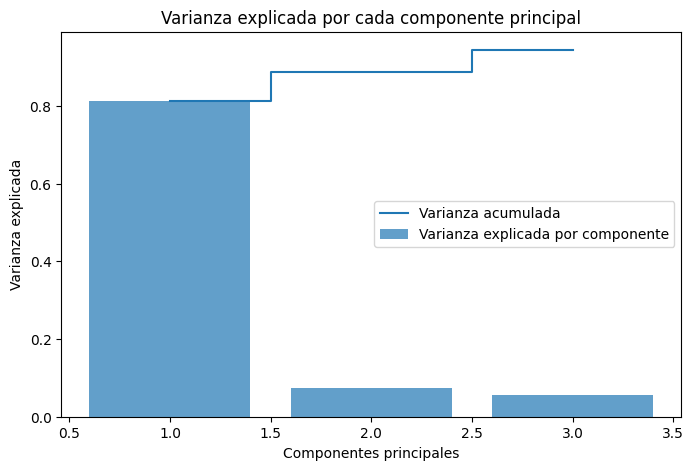

In [65]:
plt.figure(figsize=(8, 5))
plt.bar(range(1, n_components + 1), explained_variance, alpha=0.7, align='center', label='Varianza explicada por componente')
plt.step(range(1, n_components + 1), cumulative_variance, where='mid', label='Varianza acumulada')
plt.xlabel('Componentes principales')
plt.ylabel('Varianza explicada')
plt.title('Varianza explicada por cada componente principal')
plt.legend(loc='best')
plt.show()

##KMeans

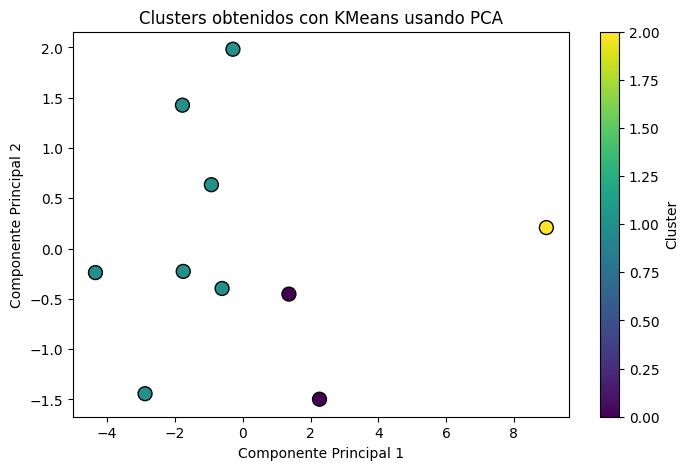

Inercia del modelo KMeans con 3 clusters: 29.619353646969707


In [66]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

n_clusters = 3

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(A)

labels = kmeans.labels_

plt.figure(figsize=(8, 5))
plt.scatter(A['pca0'], A['pca1'], c=labels, cmap='viridis', marker='o', edgecolor='k', s=100)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Clusters obtenidos con KMeans usando PCA')
plt.colorbar(label='Cluster')
plt.show()

inertia = kmeans.inertia_
print(f"Inercia del modelo KMeans con {n_clusters} clusters: {inertia}")

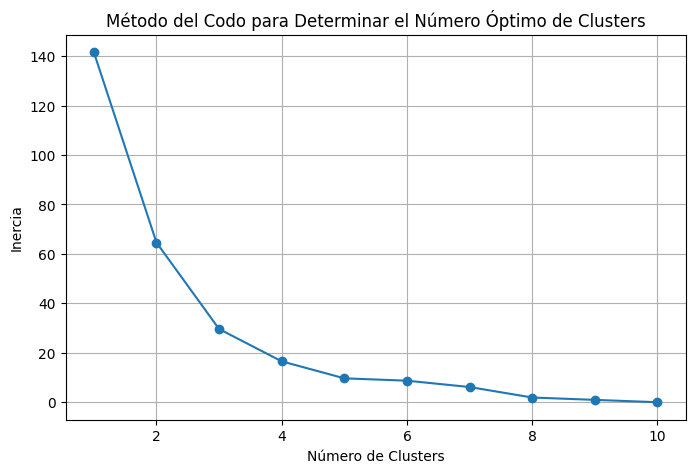

In [67]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []

range_n_clusters = range(1, 11)

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(A)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, inertia, marker='o', linestyle='-')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.title('Método del Codo para Determinar el Número Óptimo de Clusters')
plt.grid(True)
plt.show()


## Coeficiente de Silueta

In [68]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(A, labels)
print(f"Coeficiente de Silueta promedio: {silhouette_avg}")


Coeficiente de Silueta promedio: 0.33096912777368337


## Asignacion de labels

In [69]:
df_features['cluster_3'] = labels

df_features

,store_sales_ratio,avg_sales_cat_ACCESORIES,avg_sales_cat_HOME_&_GARDEN,avg_sales_cat_SUPERMARKET,ventas_T1,ventas_T2,ventas_T3,ventas_T4,ratio_ventas_en_eventos,ventas_2011,ventas_2012,ventas_2013,ventas_2014,ventas_2015,growth_rate,cluster_3
store_code,,,,,,,,,,,,,,,,
BOS_1,0.085776,2.563906,4.464155,9.034859,1189322,1338839,1398755,1269826,0.918027,784899,1075741,1086506,1102087,1147509,0.041215,1
BOS_2,0.110860,3.842335,5.033299,12.005506,1552176,1708936,1810848,1644453,0.918584,1040320,1476240,1509893,1332316,1357644,0.019011,0
BOS_3,0.092750,3.117641,4.496429,9.874560,1270261,1423469,1533950,1391560,0.919471,835327,1099587,1115644,1231701,1336981,0.085475,1
NYC_1,0.118021,5.275482,4.627781,12.847492,1613848,1833796,1933737,1768895,0.917784,1039143,1424293,1509088,1574561,1603191,0.018183,0
NYC_2,0.085147,3.820484,5.038292,8.024881,1137347,1272562,1439255,1309430,0.920560,810531,1045680,1101507,1011189,1189687,0.176523,1
NYC_3,0.171805,5.776809,8.786800,17.956773,2369606,2638215,2860873,2540082,0.920342,1490393,2124755,2208858,2313616,2271154,-0.018353,2
NYC_4,0.062549,3.364491,2.305221,6.692793,863583,961723,1013170,951041,0.918760,525944,737835,809011,844284,872443,0.033353,1
PHI_1,0.077244,3.935014,3.375857,7.966198,1093573,1162166,1200671,1223413,0.916538,529533,732797,999528,1149500,1268465,0.103493,1
PHI_2,0.097688,2.191788,4.437268,11.047155,1366385,1404849,1606412,1540786,0.921017,555957,1025102,1379489,1458043,1499841,0.028667,1


## Ficha Clusters Productos

In [70]:
features_df = df_features[[
    #'total_ventas_store',
    #'total_ventas',
    'store_sales_ratio',
    'avg_sales_cat_ACCESORIES',
    'avg_sales_cat_HOME_&_GARDEN',
    'avg_sales_cat_SUPERMARKET',
    'ventas_T1',
    'ventas_T2',
    'ventas_T3',
    'ventas_T4',
    #'ratio_eventos_ventas',
    'ratio_ventas_en_eventos',
    'ventas_2011',
    'ventas_2012',
    'ventas_2013',
    'ventas_2014',
    'ventas_2015',
    'growth_rate',
    #'adj_avg_price_cat_ACCESORIES',
    #'adj_avg_price_cat_HOME_&_GARDEN',
    #'adj_avg_price_cat_SUPERMARKET'
    'cluster_3'
    ]].groupby("cluster_3").describe().T

features_df.style.background_gradient(cmap = 'Blues', axis = 1)



---

